In [1]:
import pandas as pd

df = pd.read_parquet("cdp-minutes-item-generation-dataset/dataset.parquet")
df

,infrastructure,session_id,event_id,transcript_path,minutes_items
0,cdp-seattle-21723dcf,001f1a4e4e3c,d916e9acd175,cdp-minutes-item-generation-dataset/transcript...,"[ADOPTION OF OTHER RESOLUTIONS, PRESENTATIONS,..."
1,cdp-seattle-21723dcf,008f4e8d253c,75bb0f7c2ba4,cdp-minutes-item-generation-dataset/transcript...,"[CB 120084, CB 120083, Call To Order, Adjournm..."
2,cdp-seattle-21723dcf,015dd602acce,30411cba563e,cdp-minutes-item-generation-dataset/transcript...,"[CB 120265, Inf 2011, Public Comment, CB 12026..."
3,cdp-seattle-21723dcf,01a6d09dd442,9f581faa5ece,cdp-minutes-item-generation-dataset/transcript...,"[Inf 1736, Inf 1735, President's Report, Appro..."
4,cdp-seattle-21723dcf,01e75165fea1,9486903291a7,cdp-minutes-item-generation-dataset/transcript...,"[Approval of the Minutes, Inf 1972, Inf 1961, ..."
...,...,...,...,...,...
516,cdp-seattle-21723dcf,fd5d2f907449,34f160b4a508,cdp-minutes-item-generation-dataset/transcript...,"[ADJOURNMENT, ADOPTION OF OTHER RESOLUTIONS, C..."
517,cdp-seattle-21723dcf,fd7f4922bcc3,d0d75a1259aa,cdp-minutes-item-generation-dataset/transcript...,"[Inf 1878, Inf 1876, Session I - 9:30 a.m., In..."
518,cdp-seattle-21723dcf,fe09e3d1564f,9fc2e3743166,cdp-minutes-item-generation-dataset/transcript...,"[Approval of the Agenda, Inf 1812, Public Comm..."
519,cdp-seattle-21723dcf,fe7c8aa0dd58,7b13838e9e3e,cdp-minutes-item-generation-dataset/transcript...,"[Preview of Today’s City Council Actions, Coun..."


In [2]:
example_t_path = df.iloc[1].transcript_path
example_e_id = df.iloc[1].event_id
example_t = pd.read_csv(example_t_path)
example_t

,index,confidence,start_time,end_time,text,speaker_index,speaker_name,annotations
0,0,0.97,20.720,20.854,Will.,0,NaN,NaN
1,1,0.97,20.854,27.727,Good morning everyone.,1,NaN,NaN
2,2,0.97,27.727,29.028,Apologies for hitting the wrong button.,1,NaN,NaN
3,3,0.97,29.028,37.737,"Colleagues, we are going to get underway.",1,NaN,NaN
4,4,0.97,37.737,43.109,The May 26 to 2021 meeting of the land use and...,2,NaN,NaN
...,...,...,...,...,...,...,...,...
1310,1310,0.97,8780.872,8782.940,"Any items for the good of the order, Councilme...",333,NaN,NaN
1311,1311,0.97,8782.940,8795.553,"Seeing none, this concludes the Wednesday may ...",334,NaN,NaN
1312,1312,0.97,8795.553,8799.690,The next meeting will be June 23rd starting at...,334,NaN,NaN
1313,1313,0.97,8799.690,8800.658,Thank you all for attending.,334,NaN,NaN


In [3]:
from cdp_backend.utils.file_utils import resource_copy
import docx
from pathlib import Path
from uuid import uuid4
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer

def process_document(doc_path):
    # Try docx
    try:
        doc = docx.Document(doc_path)
        texts = []
        for para in doc.paragraphs:
            this_text = para.text.strip()
            if len(this_text) > 0:
                texts.append(this_text)

        # If we found text
        # This was a docx file
        if len(texts) > 0:
            return texts

        # If we didn't find text, it was still a docx file
        # that we just failed to parse
        # No need to try anything else in that case, just return
        return None

    # Try pdf
    except:
        try:
            reader = PdfReader(doc_path)
            texts = []
            for page in reader.pages:
                this_page_text = page.extract_text().strip()
                for para in this_page_text.split("\n"):
                    para_cleaned = para.strip()
                    if len(para_cleaned) > 0:
                        texts.append(para_cleaned)
            
            # If we found text
            # This was a pdf file
            if len(texts) > 0:
                return texts

            # If we didn't find text, it was still a pdf file
            # That we just failed to parse
            return None
        
        # It wasn't either file format
        except:
            return None

def process_file(file_model):
    try:
        # Create temp store path
        temp_store_path = Path(f"temp_{uuid4()}")

        # Store remote to local
        temp_store_path = Path(
            resource_copy(file_model.uri, dst=temp_store_path, overwrite=True),
        )

        # Get document content
        texts = process_document(temp_store_path)

        # Handle file not supported
        if texts is None:
            return None

        # Otherwise proceed
        # Encode all texts and then get the average vector
        model = SentenceTransformer("all-mpnet-base-v2")
        return model.encode(texts).mean(axis=0)
    
    # Always clear file
    finally:
        temp_store_path.unlink(missing_ok=True)

/home/eva/miniforge-pypy3/envs/testing/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from cdp_data import CDPInstances
from cdp_data.utils import connect_to_infrastructure
from cdp_backend.database import models as db_models
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# Ignore resource copy warnings
import warnings
warnings.filterwarnings("ignore", message=".*Unverified HTTPS request is being made to host.*")

# Connect to seattle
connect_to_infrastructure(CDPInstances.Seattle)

# Load model
model = SentenceTransformer("all-mpnet-base-v2")

# Pull event minutes items
emis = list(
    db_models.EventMinutesItem.collection.filter(
        "event_ref", "==", f"{db_models.Event.collection_name}/{example_e_id}"
    ).order("index").fetch()
)

# Process event minutes items
processed_emis = []
for emi in tqdm(emis):
    # Encode the minutes item name
    mi = emi.minutes_item_ref.get()
    full_mi_name = mi.name
    if mi.description is not None:
        full_mi_name = f"{full_mi_name} {mi.description}"
    
    name_vec = model.encode([full_mi_name])[0]

    # Encode all supporting docs (if there are any)
    files = list(db_models.EventMinutesItemFile.collection.filter("event_minutes_item_ref", "==", emi.key).fetch())
    file_vecs = []
    for file_model in files:
        vec_or_none = process_file(file_model)
        if vec_or_none is not None:
            file_vecs.append(vec_or_none)
    
    # Average everything together
    emi_encoding = np.stack([name_vec, *file_vecs], axis=0).mean(axis=0)
    processed_emis.append({
        "vec": emi_encoding,
        "name": full_mi_name,
        "index": emi.index,
    })
    
processed_emis_just_vecs = [emi["vec"] for emi in processed_emis]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:52<00:00, 10.25s/it]


In [5]:
windowed_sentences = (
    example_t.text.shift(2)
    + " " + example_t.text.shift(1)
    + " " + example_t.text
    + " " + example_t.text.shift(-1)
    + " " + example_t.text.shift(-2)
)
windowed_sentences = windowed_sentences.fillna("START OR END")

In [6]:
sentence_embeddings = model.encode(windowed_sentences)
sentence_embeddings_list = sentence_embeddings.tolist()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



<AxesSubplot: xlabel='Query index', ylabel='Reference index'>

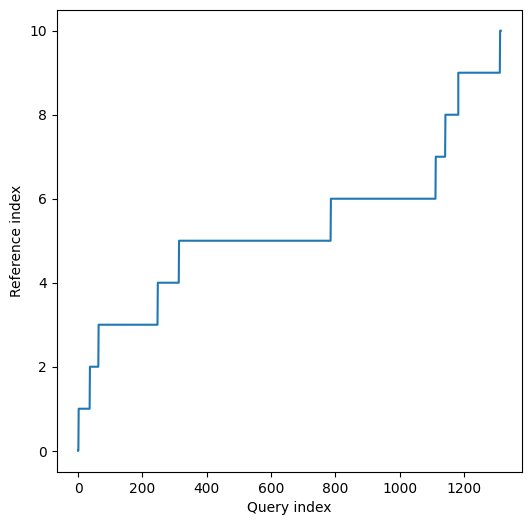

In [7]:
from dtw import dtw

result = dtw(
    sentence_embeddings_list,
    processed_emis_just_vecs,
    dist_method="cosine",
)
result.plot()

In [8]:
result.index2[:15]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
from fastdtw import fastdtw
from scipy.spatial.distance import cosine

distance, path = fastdtw(sentence_embeddings_list, processed_emis_just_vecs, dist=cosine)

# print(distance)
print(path[:15])

[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


In [10]:
example_t["minutes_item"] = [
    processed_emis[minute_index]["name"] for _, minute_index in path
]
example_t

,index,confidence,start_time,end_time,text,speaker_index,speaker_name,annotations,minutes_item
0,0,0.97,20.720,20.854,Will.,0,NaN,NaN,Call To Order
1,1,0.97,20.854,27.727,Good morning everyone.,1,NaN,NaN,Approval of the Agenda
2,2,0.97,27.727,29.028,Apologies for hitting the wrong button.,1,NaN,NaN,Approval of the Agenda
3,3,0.97,29.028,37.737,"Colleagues, we are going to get underway.",1,NaN,NaN,Approval of the Agenda
4,4,0.97,37.737,43.109,The May 26 to 2021 meeting of the land use and...,2,NaN,NaN,Approval of the Agenda
...,...,...,...,...,...,...,...,...,...
1310,1310,0.97,8780.872,8782.940,"Any items for the good of the order, Councilme...",333,NaN,NaN,CB 120085 AN ORDINANCE relating to boiler and ...
1311,1311,0.97,8782.940,8795.553,"Seeing none, this concludes the Wednesday may ...",334,NaN,NaN,CB 120085 AN ORDINANCE relating to boiler and ...
1312,1312,0.97,8795.553,8799.690,The next meeting will be June 23rd starting at...,334,NaN,NaN,Adjournment
1313,1313,0.97,8799.690,8800.658,Thank you all for attending.,334,NaN,NaN,Adjournment


In [11]:
example_t.to_csv("dtw-transcript.csv", index=False)